## DEFINICIÓN DE CONSTANTES FUNDAMENTALES  

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
D = 2 * R
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L) # coeficiente de tranferencia de calor por convección [W/(m^3 K)]
h = 1.42 * (delta_T/L)**(1/4)

## DEFINICIÓN DE VALORES ADIMENSIONALES

In [24]:
phi = 1/ (beta * delta_T)
Ri = 2 * rho_0**2 * g * beta * L * Cp**2 * delta_T /  h**2 # Numero de Richardson
Ra = rho_0**2 * g * beta * Cp * D**2 * delta_T / (16 * nu * h) # Numero de Rayleigh
LAMBDA = L/D # Relación de aspecto
delta = alpha * h / (L**2 * rho_0 * g * beta * Cp * delta_T)

print(f'Numero de Richardson: {Ri:.2e} \nNumero de Rayleigh: {Ra:.2e} \nphi: {phi:.4f}')

# Para tener un flujo laminar el numero de Rayleigh tienen que ser menor que 1e9

Numero de Richardson: 2.83e+02 
Numero de Rayleigh: 2.55e+06 
phi: 4.5413


## CALCULO DE v_e POR NEWTON-RAPHSON

In [25]:
def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - math.exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + 1/v)*math.exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
        if abs(v_new - v) < tol:
            return v_new, i+1
        v = v_new
    return v  # Returns the last approximation if it doesn't converge


v_0 = newton_raphson(phi, Ri, Ra, LAMBDA)
print(f"Solution: v_e = {v_0:.6f}")

v_e = v_0


Solution: v_e = 7.241852


## LA VELOCIDAD EN EL ESTACIONARIO SERÁ

In [26]:
u_e = v_e * h_v * L / (rho_0 * Cp)
print(f'u_e = {u_e:.2f} m/s o {u_e*3.6:.2f} km/h')

u_e = 9.39 m/s o 33.81 km/h


## DISTRIBUCIÓN DE TEMPERATURAS

El valor de theta cuando eta = 1 es: 0.4986


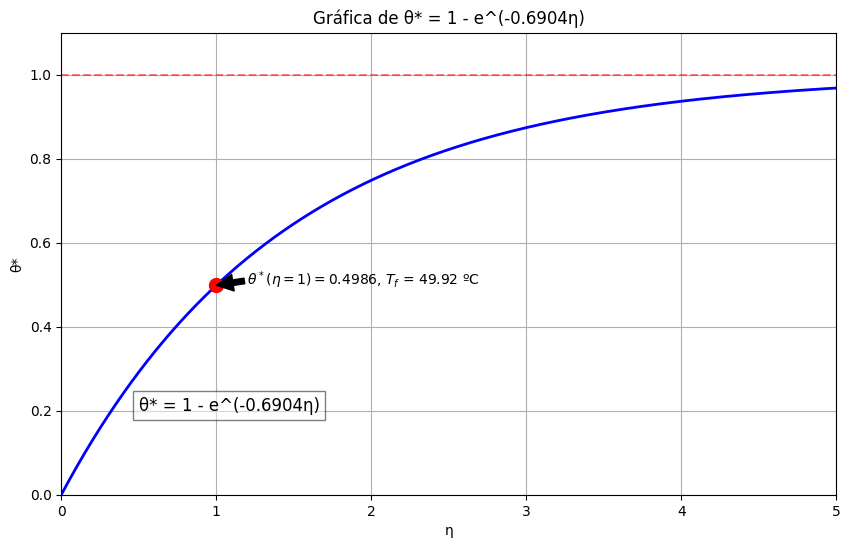

In [27]:
def theta_estrella(eta, LAMBDA, v_e):
    a = LAMBDA / v_e
    return 1 - np.exp(-a * eta)

# Crear un rango de valores para eta
eta = np.linspace(0, 5, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
theta = theta_estrella(eta, LAMBDA, v_e)

# Calcular theta cuando eta = 1
eta_1 = 1
theta_1 = theta_estrella(eta_1, LAMBDA, v_e)

# Calculo de la temperatura en K
T_f = delta_T * theta_1 + T_a

a = LAMBDA/ v_e

print(f"El valor de theta cuando eta = 1 es: {theta_1:.4f}")

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, theta, 'b-', linewidth=2)
plt.title(f'Gráfica de θ* = 1 - e^(-{a:.4f}η)')
plt.xlabel('η')
plt.ylabel('θ*')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, 1.1)

# Marcar el punto (1, theta_1) en la gráfica
plt.plot(1, theta_1, 'ro', markersize=10)  # 'ro' significa un punto rojo
plt.annotate(r'$\theta^* (\eta = 1) = $' + f'{theta_1:.4f}' + f', $T_f$ = {T_f-273:.2f} ºC', xy=(1, theta_1), xytext=(1.2, theta_1),
             arrowprops=dict(facecolor='black', shrink=0.005))

# Añadir una ecuación en la gráfica
plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


## DISTRIBUCIÓN DE PRESIONES

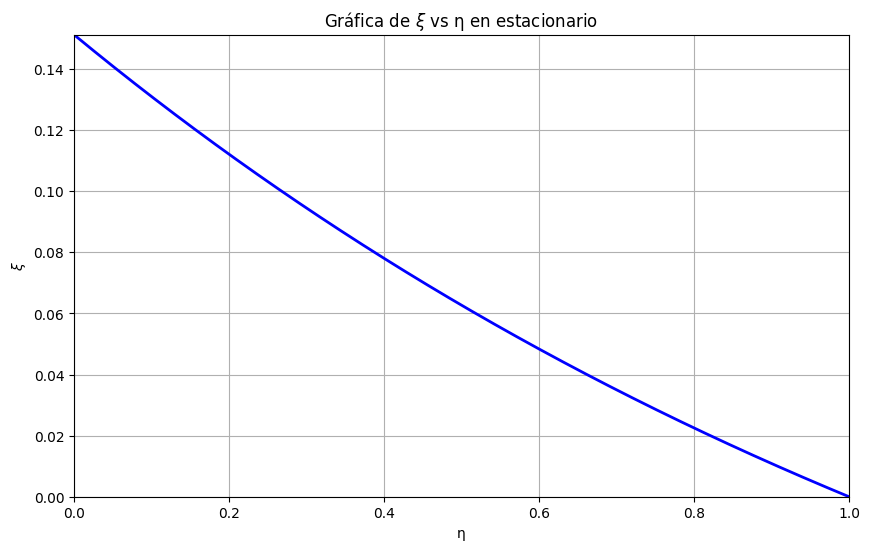

In [28]:
def xi_fun(eta, v_e, Ra, phi, LAMBDA):
    return v_e**2 / (Ra * phi) * (1 - eta) - LAMBDA / (phi * v_e) * (1 - np.exp(-(LAMBDA/v_e) * (eta - 1)))

# Crear un rango de valores para eta
eta = np.linspace(0, 1, 1000)  # Ajusta el rango según sea necesario

# Calcular theta_estrella para cada valor de eta
xi_dist = xi_fun(eta, v_e, Ra, phi, LAMBDA)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(eta, xi_dist, 'b-', linewidth=2)
plt.title(f'Gráfica de ' + r'$\xi$ vs η en estacionario')
plt.xlabel('η')
plt.ylabel(r'$\xi$')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)  # Línea asintótica en y=1
plt.xlim(0, max(eta))
plt.ylim(0, max(xi_dist))

# Añadir una ecuación en la gráfica
#plt.text(0.5, 0.2, f'θ* = 1 - e^(-{a:.4f}η)', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## VARIACIÓN DE PARAMETROS 

# Extremos de los valoresd De $\Lambda$, $\phi$, Ri y Ra. + valores para la representación

In [29]:
temperaturas = np.array([10, 1000])
LAMBDA_extremos = [1, 10**3]
phi_extremos = 1/ (beta * temperaturas)
Ri_extremos = 2 * rho_0**2 * g * beta * L * Cp**2 * temperaturas /  h**2 
Ra_extremos = rho_0**2 * g * beta * Cp * D**2 * temperaturas / (16 * nu * h) 

print('LAMBDA ' + str(LAMBDA_extremos) + '\nphi ' + str(phi_extremos) + '\nRi ' + str(Ri_extremos) + '\nRa ' + str(Ra_extremos))

resolucion = 100

# Definir los rangos para los ejes
phi_range = np.linspace(phi_extremos[0], phi_extremos[1], resolucion)
LAMBDA_range = np.linspace(LAMBDA_extremos[0], LAMBDA_extremos[1], resolucion)
Ri_range = np.linspace(Ri_extremos[0], Ri_extremos[1], resolucion)
Ra_range = np.linspace(Ra_extremos[0], Ra_extremos[1], resolucion)

LAMBDA [1, 1000]
phi [27.2479564   0.27247956]
Ri [  47.16619549 4716.6195487 ]
Ra [  425785.03544995 42578503.54499479]


## Definición de valores constantes para el calculo de iscontornos

In [30]:
LAMBDA_cte = 10
Ri_cte = 10**2
Ra_cte = 10**6

In [31]:
import numpy as np
from scipy.optimize import fsolve

# Define a safe exponential function
def safe_exp(x):
    try:
        return np.exp(x) if x < 700 else np.inf
    except:
        return np.inf

# Define functions
def f(v, phi, Ri, Ra, LAMBDA):
    return phi + Ri**-1 * v**2 + Ra**-1 * v - 1 + (v/LAMBDA) * (1 - safe_exp(-LAMBDA/v))

def f_prime(v, Ri, Ra, LAMBDA):
    return 2 * Ri**-1 * v + Ra**-1 + (1/LAMBDA) * (1 - (1 + LAMBDA/v)*safe_exp(-LAMBDA/v))

def newton_raphson(phi, Ri, Ra, LAMBDA, v0=0.1, tol=1e-6, max_iter=100):
    v = v0
    for i in range(max_iter):
        try:
            v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)
            if abs(v_new - v) < tol:
                return v_new
            v = v_new
        except:
            return np.nan
    return np.nan  # Return NaN if it doesn't converge

def calculate_theta(LAMBDA, v):
    return 1 - safe_exp(-LAMBDA/v)

# Initialize matrices
v_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
v_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))
v_Ra_phi = np.zeros((len(phi_range), len(Ra_range)))

theta_lambda_phi = np.zeros((len(phi_range), len(LAMBDA_range)))
theta_Ri_phi = np.zeros((len(phi_range), len(Ri_range)))
theta_Ra_phi = np.zeros((len(phi_range), len(Ra_range)))

# Fill matrices
for i in range(resolucion):
    for j in range(resolucion):
        try:
            # LAMBDA and phi variables
            v = newton_raphson(phi_range[j], Ri_cte, Ra_cte, LAMBDA_range[i])
            v_lambda_phi[i, j] = v
            theta_lambda_phi[i, j] = calculate_theta(LAMBDA_range[i], v)
            
            # Ri and phi variables
            v = newton_raphson(phi_range[j], Ri_range[i], Ra_cte, LAMBDA_cte)
            v_Ri_phi[i, j] = v
            theta_Ri_phi[i, j] = calculate_theta(LAMBDA_cte, v)
            
            # Ra and phi variables
            v = newton_raphson(phi_range[j], Ri_cte, Ra_range[i], LAMBDA_cte)
            v_Ra_phi[i, j] = v
            theta_Ra_phi[i, j] = calculate_theta(LAMBDA_cte, v)
        except:
            print(f"Error at i={i}, j={j}")
            v_lambda_phi[i, j] = np.nan
            theta_lambda_phi[i, j] = np.nan
            v_Ri_phi[i, j] = np.nan
            theta_Ri_phi[i, j] = np.nan
            v_Ra_phi[i, j] = np.nan
            theta_Ra_phi[i, j] = np.nan

print("Matrices created successfully.")


/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_1025/2779759268.py:22: RuntimeWarning: invalid value encountered in scalar divide
  v_new = v - f(v, phi, Ri, Ra, LAMBDA) / f_prime(v, Ri, Ra, LAMBDA)


Matrices created successfully.


/var/folders/lx/vhxvbgp94fj63r8wrldf_13m0000gn/T/ipykernel_1025/1466728560.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 8e-1)


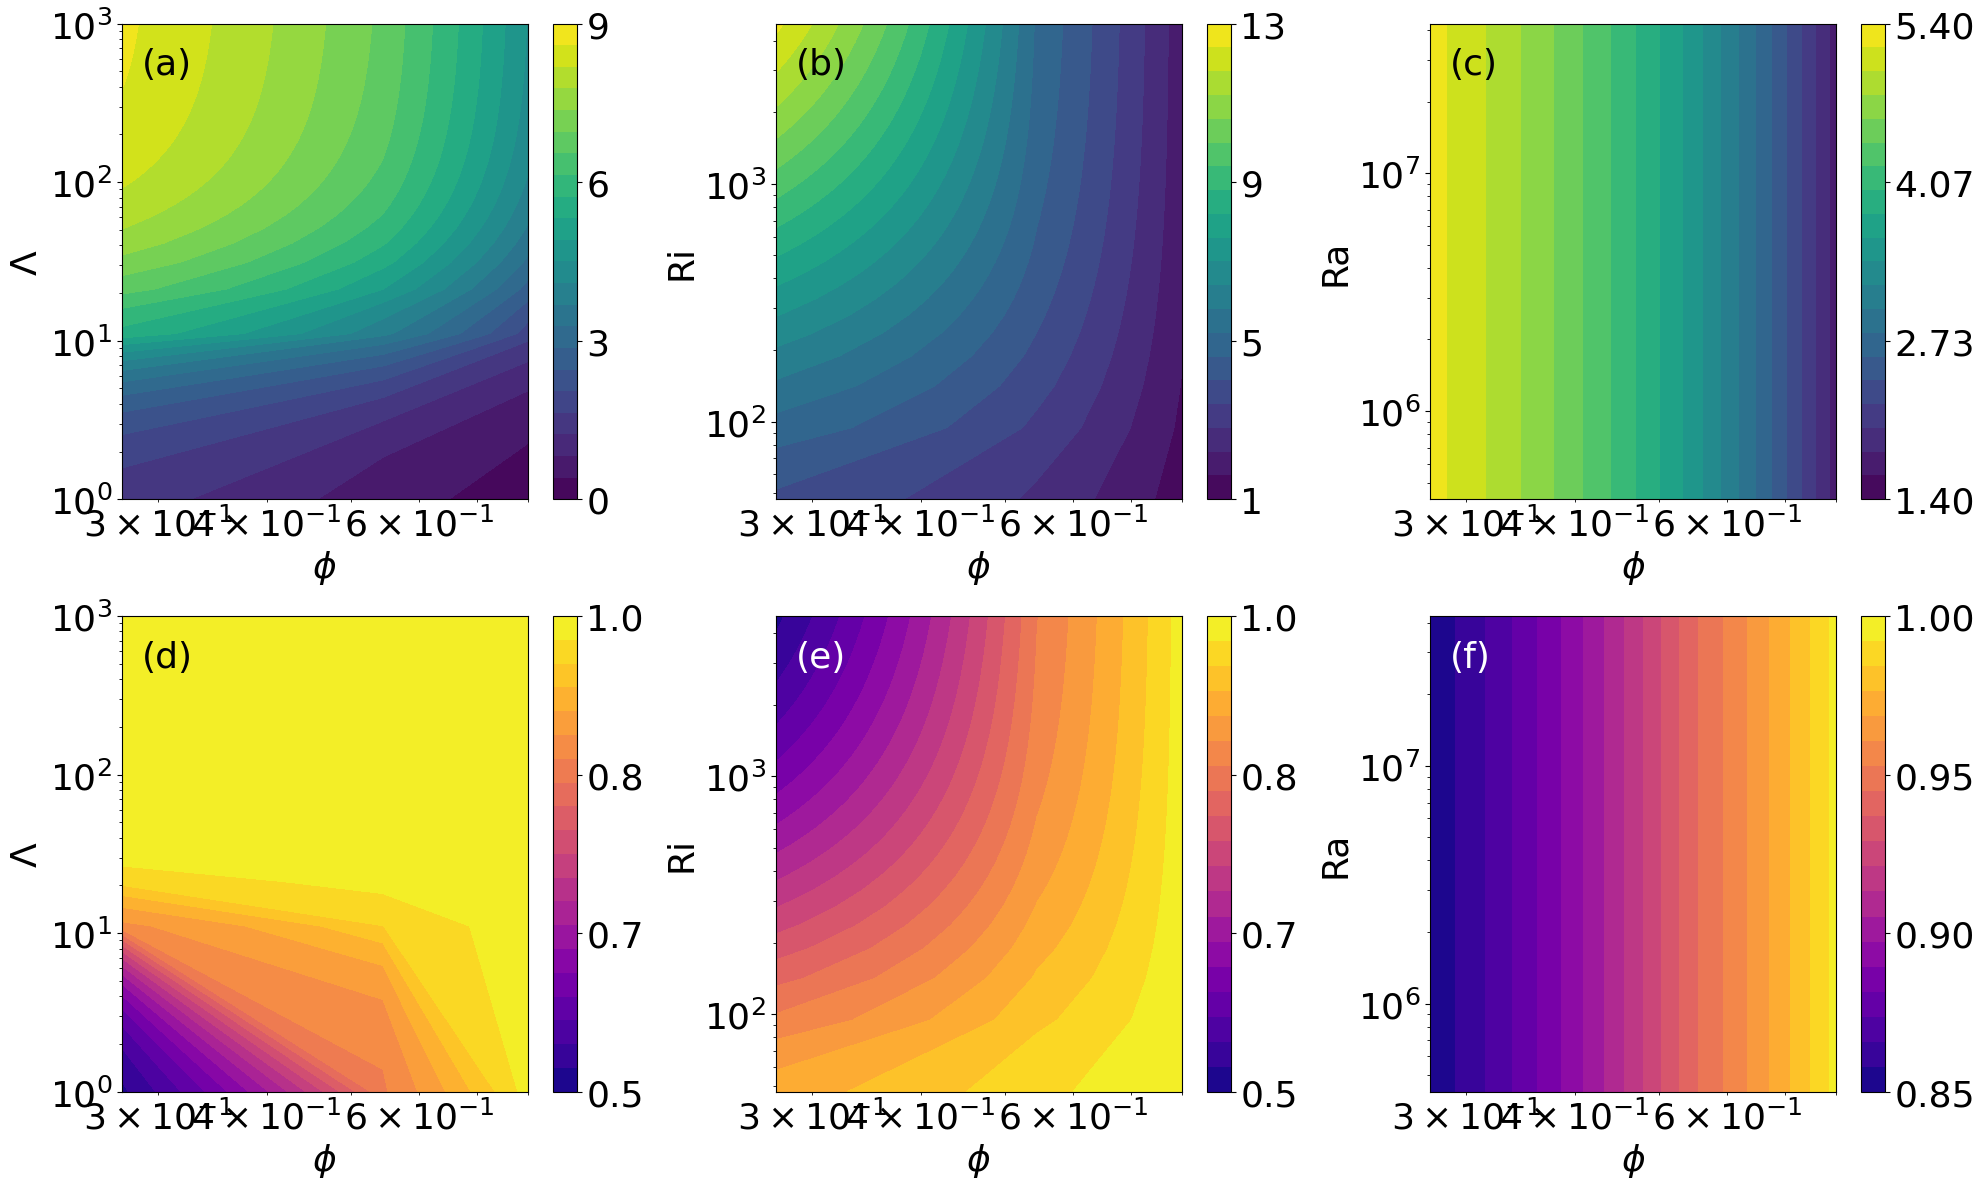

In [60]:
from matplotlib.ticker import FuncFormatter
import numpy as np

# Crear una figura con 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Función para formatear los ticks
def format_func(value, tick_number, decimals):
    return f'{value:.{decimals}f}'

def format_x_ticks(value, tick_number):
    if value < 0.01:
        return f'{value:.1e}'  # Notación científica para valores muy pequeños
    else:
        return f'{value:.1f}'  # Un decimal para otros valores


def setup_subplot(ax, im, xlabel, ylabel, letter):
    ax.set_xlabel(xlabel, fontsize=26)
    ax.set_ylabel(ylabel, fontsize=26, rotation = 90)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0, 8e-1)
    
    # Obtener los valores mínimo y máximo de los datos
    vmin, vmax = im.get_clim()
    
    # Crear 4 ticks espaciados uniformemente
    ticks = np.linspace(vmin, vmax, 4)
    
    cbar = fig.colorbar(im, ax=ax, ticks=ticks)
    cbar.ax.tick_params(labelsize=26)  # Cambiar el tamaño de la fuente de la colorbar
    
    # Formatear los ticks según la gráfica
    if letter in 'ab':  # Gráficas 'a' y 'b' sin decimales
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: f'{value:.0f}'))
    elif letter in 'cf':  # Gráficas 'c' y 'f' con 2 decimales
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 2)))
    else:  # Otras gráficas con 1 decimal
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda value, tick_number: format_func(value, tick_number, 1)))
    
    color = 'black' if letter in 'abcd' else 'white'
    ax.text(0.05, 0.95, f'({letter})', transform=ax.transAxes, 
            ha='left', va='top', fontsize=26, color=color)
   

    ax.yaxis.set_tick_params(which='both', labelsize=26)
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.xaxis.set_tick_params(which='both', labelsize=26)

    # Aplicar los cambios
    ax.figure.canvas.draw()

# Lista de parámetros para cada subplot
subplot_params = [
    (v_lambda_phi, r'$\phi$', r'$\Lambda$', LAMBDA_range),
    (v_Ri_phi, r'$\phi$', 'Ri', Ri_range),
    (v_Ra_phi, r'$\phi$', 'Ra', Ra_range),
    (theta_lambda_phi, r'$\phi$', r'$\Lambda$', LAMBDA_range),
    (theta_Ri_phi, r'$\phi$', 'Ri', Ri_range),
    (theta_Ra_phi, r'$\phi$', 'Ra', Ra_range)
]

# Crear subplots
for i, (data, xlabel, ylabel, y_range) in enumerate(subplot_params):
    row = i // 3
    col = i % 3
    letter = chr(97 + i)  # 'a' to 'f'
    cmap = 'viridis' if i < 3 else 'plasma'
    
    im = axs[row, col].contourf(phi_range, y_range, data, levels=20, cmap=cmap)
    setup_subplot(axs[row, col], im, xlabel, ylabel, letter)
    axs[row, col].set_ylim(min(y_range), max(y_range))

# Después del bucle for que crea los subplots
for ax in axs.flat:
    ax.xaxis.set_major_formatter(FuncFormatter(format_x_ticks))
    ax.figure.canvas.draw()


plt.tight_layout()
plt.show()



fontsize para color bar y eje x
blender


quitar titulos, figura cuadrada, tamaño 26